# BPNet LSTM Experiments

This notebook summarizes the experiments we ran for the BPNet project. We compare two implementations:

- **LSTM Simple** – the original 2-layer, 128-hidden LSTM stack (no scheduler or weight decay).
- **LSTM Tuned** – the larger 3-layer, 256-hidden LSTM with scheduling/regularization knobs.

For each model we train on different dataset sizes (20k vs. 50k segments, etc.) and visualize how the validation metrics evolve. The notebook automatically scans the `runs/` directory for training logs, so whenever we add a new run the tables and plots update automatically.

## 1. Imports & Utility Helpers

In [1]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')
ROOT = Path.cwd()
if not (ROOT / 'runs').exists():
    ROOT = ROOT.parent
RUNS_ROOT = ROOT / 'runs'
print(f'Notebook root: {ROOT}')


Notebook root: /Users/sndichu/Desktop/csci1470/BPNet


## 2. Load Metrics from All Runs

Each training run writes a `metrics.csv` plus a `config.json`. We parse both to recover the model type, dataset slice, and per-epoch statistics.

In [2]:
def infer_dataset(train_mat: str) -> str:
    name = train_mat.lower()
    if '50k' in name:
        return '50k segments'
    if 'x10' in name or '200k' in name:
        return '200k segments'
    if 'train_subset' in name:
        return 'full subset mat'
    if 'oscar' in name:
        return '20k segments'
    return 'unknown'


def infer_model(log_dir: Path, config: dict) -> str:
    log_name = str(log_dir).lower()
    if 'simple' in log_name or not config:
        return 'lstm_simple'
    return 'lstm_tuned'

records = []
for metrics_path in RUNS_ROOT.rglob('metrics.csv'):
    log_dir = metrics_path.parent
    config_path = log_dir / 'config.json'
    config = {}
    if config_path.exists():
        with open(config_path) as f:
            config = json.load(f)
    df = pd.read_csv(metrics_path)
    train_mat = config.get('train_mat', '')
    dataset = infer_dataset(train_mat)
    model_type = infer_model(log_dir, config)
    for _, row in df.iterrows():
        records.append({
            'log_dir': str(log_dir.relative_to(ROOT)),
            'model': model_type,
            'dataset': dataset,
            'epoch': int(row['epoch']),
            'lr': row.get('lr'),
            'train_loss': row['train_loss'],
            'train_mae': row.get('train_mae'),
            'train_rmse': row.get('train_rmse'),
            'train_corr': row.get('train_corr'),
            'val_loss': row.get('val_loss'),
            'val_mae': row.get('val_mae'),
            'val_rmse': row.get('val_rmse'),
            'val_corr': row.get('val_corr'),
        })

metrics_df = pd.DataFrame(records)
if metrics_df.empty:
    raise RuntimeError('No metrics.csv files found. Make sure training runs have logged metrics.')

metrics_df.head()

,log_dir,model,dataset,epoch,lr,train_loss,train_mae,train_rmse,train_corr,val_loss,val_mae,val_rmse,val_corr
0,runs/oscar_npz_x10/20251211_024533,lstm_tuned,200k segments,1,0.0005,405.005457,14.451528,20.124725,0.546778,261.378390,12.221610,16.167196,0.724933
1,runs/oscar_npz_tuned/20251211_021339,lstm_tuned,20k segments,1,0.0005,1661.221054,31.814354,40.758102,0.014512,416.757365,15.318620,20.414627,0.542868
2,runs/oscar_npz_tuned/20251211_021339,lstm_tuned,20k segments,2,0.0005,318.197929,13.572806,17.838102,0.630483,289.410680,13.059119,17.012081,0.667888
3,runs/oscar_npz_tuned/20251211_021339,lstm_tuned,20k segments,3,0.0005,289.217542,13.005353,17.006395,0.668142,286.189608,12.846154,16.917133,0.688084
4,runs/oscar_npz_tuned/20251211_021339,lstm_tuned,20k segments,4,0.0005,279.191598,12.766616,16.709023,0.682317,270.505797,12.732741,16.447058,0.694909


## 3. Best-epoch Summary

We aggregate the best validation loss and corresponding correlation for each (model, dataset, run) combination.

In [3]:
summary = (metrics_df.dropna(subset=['val_loss'])
                     .groupby(['log_dir', 'model', 'dataset'])
                     .agg(best_val_loss=('val_loss', 'min'),
                          best_val_corr=('val_corr', 'max'),
                          epochs=('epoch', 'max'))
                     .reset_index())
summary.sort_values('best_val_loss').reset_index(drop=True)

,log_dir,model,dataset,best_val_loss,best_val_corr,epochs
0,runs/oscar_npz_50k/20251211_042014,lstm_tuned,50k segments,206.857446,0.779089,15
1,runs/oscar_npz_50k/20251211_033011,lstm_tuned,50k segments,211.039022,0.771322,12
2,runs/oscar_npz_tuned/20251210_091040,lstm_tuned,20k segments,214.970126,0.766659,30
3,runs/oscar_npz_tuned/20251211_021339,lstm_tuned,20k segments,216.642918,0.768493,30
4,runs/oscar_npz/20251210_081904,lstm_tuned,20k segments,227.631749,0.753279,20
5,runs/oscar_npz_tuned/20251210_083442,lstm_tuned,20k segments,235.128779,0.742660,20
6,runs/oscar_npz_x10/20251211_024533,lstm_tuned,200k segments,261.378390,0.724933,1


## 4. Validation Curves

The following plots compare how validation loss/correlation evolve for each configuration. Use the legend to distinguish runs and dataset sizes.

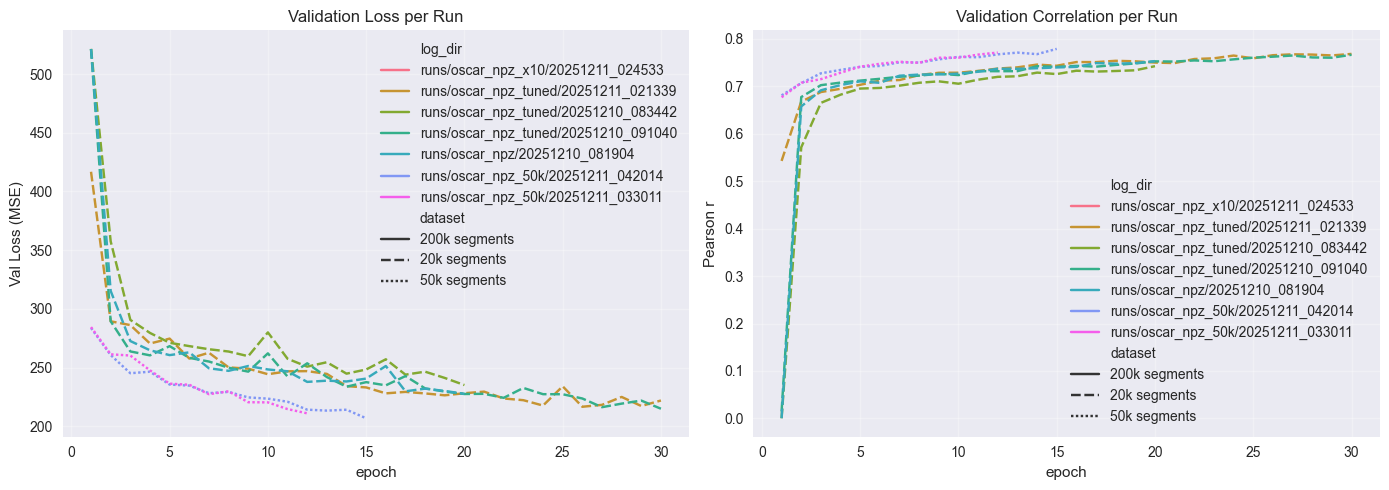

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.lineplot(data=metrics_df, x='epoch', y='val_loss', hue='log_dir', style='dataset', ax=axes[0])
axes[0].set_title('Validation Loss per Run')
axes[0].set_ylabel('Val Loss (MSE)')
axes[0].grid(alpha=0.3)

sns.lineplot(data=metrics_df, x='epoch', y='val_corr', hue='log_dir', style='dataset', ax=axes[1])
axes[1].set_title('Validation Correlation per Run')
axes[1].set_ylabel('Pearson r')
axes[1].grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Sample Predictions

For qualitative inspection we load the latest `epoch_*_samples.npz` stored inside a run directory and plot the first few target/pred pairs.

Previewing samples for runs/oscar_npz_50k/20251211_042014


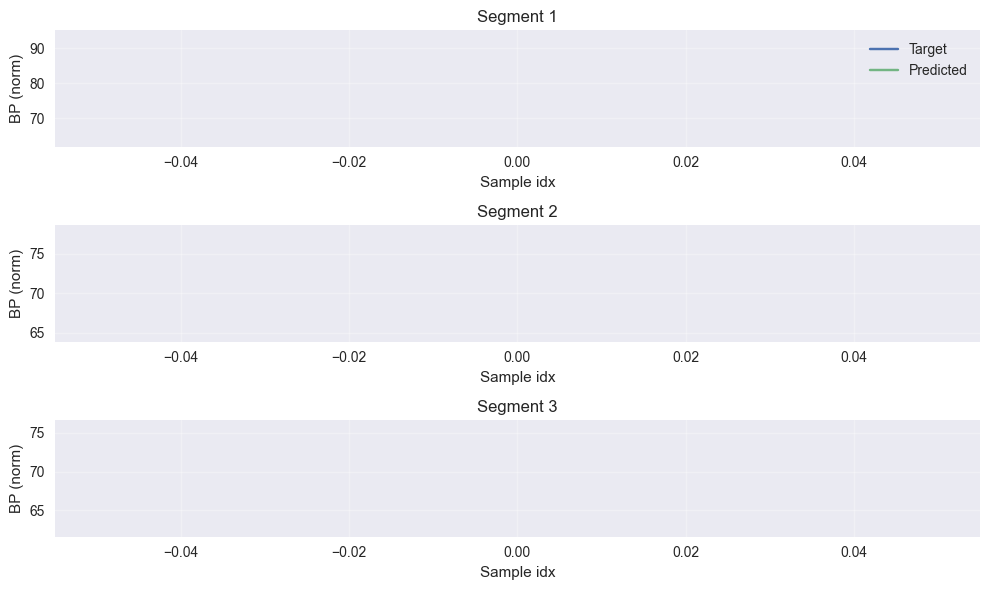

In [5]:
def preview_samples(log_dir: Path, max_pairs: int = 3):
    sample_files = sorted(log_dir.glob('epoch_*_samples.npz'))
    if not sample_files:
        print(f'No sample files for {log_dir}')
        return
    data = np.load(sample_files[-1])
    targets, preds = data['target_bp'], data['pred_bp']
    pairs = min(max_pairs, targets.shape[0])
    fig, axes = plt.subplots(pairs, 1, figsize=(10, 2 * pairs))
    if pairs == 1:
        axes = [axes]
    t = np.arange(targets.shape[-1])
    for i in range(pairs):
        axes[i].plot(t, targets[i, 0], label='Target')
        axes[i].plot(t, preds[i, 0], label='Predicted', alpha=0.8)
        axes[i].set_title(f'Segment {i+1}')
        axes[i].set_xlabel('Sample idx')
        axes[i].set_ylabel('BP (norm)')
        axes[i].grid(alpha=0.3)
    axes[0].legend()
    plt.tight_layout()
    plt.show()

best_log = summary.sort_values('best_val_loss').iloc[0]['log_dir']
print(f'Previewing samples for {best_log}')
preview_samples(ROOT / best_log)

## 6. Focused Configuration Set

We highlight four scenarios for comparison:

1. **Simple – 20k** (baseline LSTM, 20k segments)
2. **Simple – 50k**
3. **Tuned – 20k**
4. **Tuned – 50k**

The following cells filter `metrics_df` down to these runs so we can compare apples-to-apples.


In [6]:
target_keys = {
    "Simple – 20k": "simple_oscar20k",
    "Simple – 50k": "simple_oscar50k",
    "Tuned – 20k": "oscar_npz_tuned",
    "Tuned – 50k": "oscar_npz_50k",
}
focus_frames = []
for label, key in target_keys.items():
    mask = metrics_df['log_dir'].str.contains(key, na=False)
    subset = metrics_df[mask].copy()
    if subset.empty:
        print(f"Warning: no runs found for {label}")
        continue
    subset['configuration'] = label
    focus_frames.append(subset)
focus_df = pd.concat(focus_frames, ignore_index=True) if focus_frames else pd.DataFrame()
focus_df.head()

,log_dir,model,dataset,epoch,lr,train_loss,train_mae,train_rmse,train_corr,val_loss,val_mae,val_rmse,val_corr,configuration
0,runs/oscar_npz_tuned/20251211_021339,lstm_tuned,20k segments,1,0.0005,1661.221054,31.814354,40.758102,0.014512,416.757365,15.318620,20.414627,0.542868,Tuned – 20k
1,runs/oscar_npz_tuned/20251211_021339,lstm_tuned,20k segments,2,0.0005,318.197929,13.572806,17.838102,0.630483,289.410680,13.059119,17.012081,0.667888,Tuned – 20k
2,runs/oscar_npz_tuned/20251211_021339,lstm_tuned,20k segments,3,0.0005,289.217542,13.005353,17.006395,0.668142,286.189608,12.846154,16.917133,0.688084,Tuned – 20k
3,runs/oscar_npz_tuned/20251211_021339,lstm_tuned,20k segments,4,0.0005,279.191598,12.766616,16.709023,0.682317,270.505797,12.732741,16.447058,0.694909,Tuned – 20k
4,runs/oscar_npz_tuned/20251211_021339,lstm_tuned,20k segments,5,0.0005,273.836001,12.644069,16.547991,0.689748,274.680812,12.589954,16.573496,0.703412,Tuned – 20k


## 7. Performance Snapshot

We compare validation loss/correlation across the four configurations. Use this to assess how model capacity and dataset size interact.


,configuration,log_dir,best_val_loss,best_val_corr,epochs
0,Tuned – 20k,runs/oscar_npz_tuned/20251210_083442,235.128779,0.742660,20
1,Tuned – 20k,runs/oscar_npz_tuned/20251210_091040,214.970126,0.766659,30
2,Tuned – 20k,runs/oscar_npz_tuned/20251211_021339,216.642918,0.768493,30
3,Tuned – 50k,runs/oscar_npz_50k/20251211_033011,211.039022,0.771322,12
4,Tuned – 50k,runs/oscar_npz_50k/20251211_042014,206.857446,0.779089,15


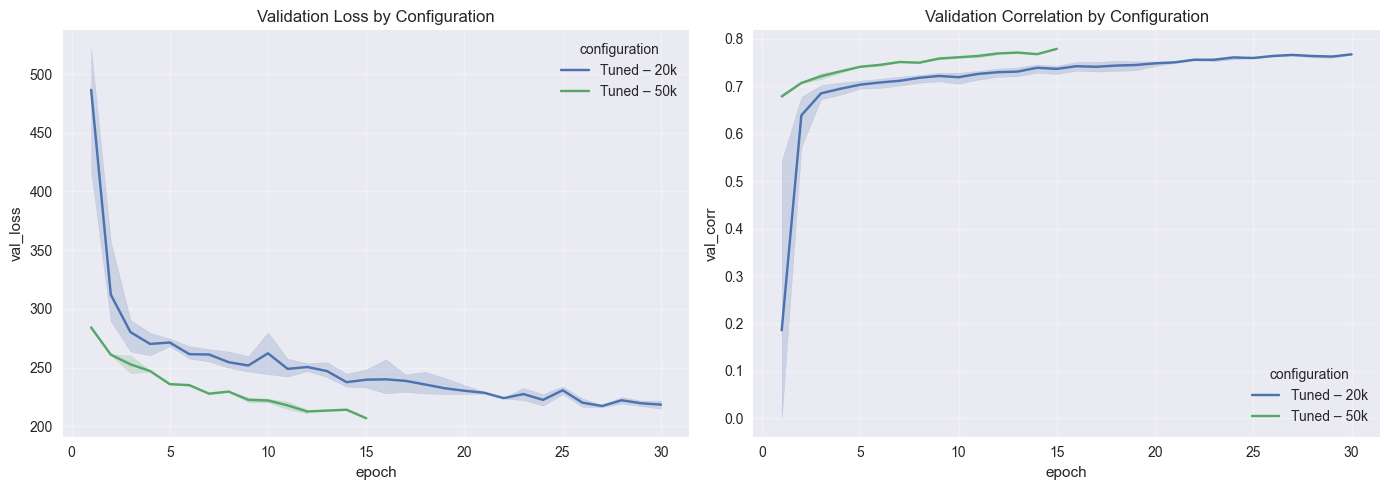

In [7]:
if not focus_df.empty:
    focus_summary = (focus_df.dropna(subset=['val_loss'])
                     .groupby(['configuration', 'log_dir'])
                     .agg(best_val_loss=('val_loss', 'min'),
                          best_val_corr=('val_corr', 'max'),
                          epochs=('epoch', 'max'))
                     .reset_index())
    display(focus_summary)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    sns.lineplot(data=focus_df, x='epoch', y='val_loss', hue='configuration', ax=axes[0])
    axes[0].set_title('Validation Loss by Configuration')
    axes[0].grid(alpha=0.3)

    sns.lineplot(data=focus_df, x='epoch', y='val_corr', hue='configuration', ax=axes[1])
    axes[1].set_title('Validation Correlation by Configuration')
    axes[1].grid(alpha=0.3)
    plt.tight_layout()
else:
    print('No focused configurations available.')

## 8. Architecture Reference


## 9. Takeaways
